In [2]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
import json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
sw_nltk.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
import re
import spacy
import os

from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_val_score, )
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tomotopy import HDPModel

#from lda_classification.model import TomotopyLDAVectorizer
#from lda_classification.preprocess.spacy_cleaner import SpacyCleaner
import gensim
import gensim.corpora as corpora
import pyLDAvis
#import pyLDAvis.gensim_models as gensim
pyLDAvis.enable_notebook()
#import pyLDAvis.gensim
import pickle 

from matplotlib import pyplot as plt
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
workers = 4 #Numbers of workers throughout the project
use_umap = False #make this True if you want to use UMAP for your visualizations
min_df = 5 #Minimum number for document frequency in the corpus
rm_top = 5 #Remove top n frequent words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#lem for lemmatization, stem for stemmatizing
def preprocess(data, type="lem"):
    words = set(nltk.corpus.words.words())
    preprocessed_data = []
    for x in data:
        #Lowerize
        x = x.lower()
        #Eliminate special characters
        x = re.sub(r'\d+', '', x)
        x = re.sub(' +', ' ', x.translate ({ord(c): "" for c in "!@#$%^&*()[]{};:,./<>?\\|'`~-=_+"}).strip())
        
        #Eliminate stop words
        words = [word for word in x.split() if word not in sw_nltk] 
        x = " ".join(words)

        #Stemming / Lemmatizing
        words = word_tokenize(x)
        rootWords = []
        if type=='stem':
                ps = PorterStemmer()
                rootWords.append(ps.stem(w))
        else:
            for w in words:
                wordnet_lemmatizer = WordNetLemmatizer()
                rootWords.append(wordnet_lemmatizer.lemmatize(w))

        x = x.split(' ')
        #x = TreebankWordDetokenizer().detokenize(rootWords)

        nlp = spacy.load("en_core_web_sm")
        
        article = []
        for sent in x:
            doc = nlp(sent)
            j = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]
            
            if (j != []):
                #print(j)
                #print(j[0] in words)
                #print(j[0].isalpha())
                if((j[0] in words) or (j[0].isalpha())):
                    article.append(j[0])
        
        if article != []:
            preprocessed_data.append(article)

        #print(article)
    return preprocessed_data
        
    


#preprocess(['Hsf##123 14: . ; ,  45', 'Blu34%& 22', 'as fine as good', 'found, find, go, went', 'studies studying cries cry'])

[['fine'], ['find', 'find', 'go'], ['study', 'study', 'cry', 'cry']]

In [4]:
# Opening JSON file
f_queries = open('Queries_Labeled.json',)
f_collection = open('collection.json')
 
# returns JSON object as
# a dictionary
data_queries = json.load(f_queries)
data_collection = json.load(f_collection)

# Iterating through the json
# list
#for i in data['documents']:
#    print(i)

queries = data_queries['documents']
collection = data_collection['TREC']['DOC']
#print(len(queries))
#print(len(collection))

# Closing file
f_queries.close()
f_collection.close()

prep_collection = []
for x in collection:
    prep_collection.append(x['text'])
prep_collection = preprocess(prep_collection)

prep_queries = []
for x in queries:
    prep_queries.append(x['text'])
prep_queries = preprocess(prep_queries)

#print(prep_queries)
#print(prep_collection)

In [5]:
# Create Dictionary
id2word = corpora.Dictionary(prep_collection)
# Create Corpus
texts = prep_collection
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [15]:
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"system" + 0.009*"information" + 0.006*"use" + 0.006*"give" + '
  '0.006*"service" + 0.005*"field" + 0.005*"library" + 0.005*"datum" + '
  '0.004*"pm" + 0.004*"describe"'),
 (1,
  '0.009*"describe" + 0.007*"method" + 0.007*"use" + 0.006*"pm" + '
  '0.005*"analysis" + 0.005*"field" + 0.005*"frequency" + 0.005*"system" + '
  '0.004*"wave" + 0.004*"give"'),
 (2,
  '0.011*"information" + 0.009*"library" + 0.007*"use" + 0.007*"frequency" + '
  '0.006*"electron" + 0.006*"system" + 0.005*"service" + 0.005*"circuit" + '
  '0.005*"method" + 0.005*"give"'),
 (3,
  '0.014*"system" + 0.009*"information" + 0.009*"datum" + 0.007*"computer" + '
  '0.006*"library" + 0.006*"design" + 0.005*"use" + 0.005*"circuit" + '
  '0.005*"describe" + 0.005*"method"')]


In [16]:
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    #LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

C:\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.015841  0.020090       1        1  29.598991
2      0.010345 -0.004378       2        1  28.337627
0      0.006535 -0.020050       3        1  25.896221
1     -0.032720  0.004338       4        1  16.167161, topic_info=            Term         Freq        Total Category  logprob  loglift
2             pm   824.000000   824.000000  Default  30.0000  30.0000
21      describe  1331.000000  1331.000000  Default  29.0000  29.0000
254       method  1215.000000  1215.000000  Default  28.0000  28.0000
392     electron   744.000000   744.000000  Default  27.0000  27.0000
0       computer   937.000000   937.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
227         high   100.488457   592.203146   Topic4  -5.9818   0.0484
200  information   128.986567  2079.379006   Topic4  -5.7321  -0.9579
157        paper    98.857574   563.350958   Topic4  -5.9981   0.0820
224        datum   114.021322  1270.652361   Topic4  -5.8554  -0.5887
158      present   105.439803   891.056666   Topic4  -5.9337  -0.3121

[400 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
5272      1  0.664696  abstractingindexe
5473      1  0.664796                ace
9350      1  0.182128             alfven
9350      2  0.182128             alfven
9350      3  0.728514             alfven
...     ...       ...                ...
6996      4  0.110443             yellow
2446      1  0.159584               zone
2446      2  0.159584               zone
2446      3  0.585141               zone
2446      4  0.088658               zone

[837 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

In [11]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=collection):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=prep_collection)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8818,"information, system, service, frequency, descr...","[computer, university, part, reeve, r, pm]"
1,1,2.0,0.9927,"system, datum, use, information, describe, giv...","[use, synthetic, image, register, real, image,..."
2,2,0.0,0.6559,"information, system, frequency, network, libra...","[training, assistant, mauritius, university, m..."
3,3,4.0,0.7931,"system, method, field, library, use, informati...","[electrostatic, centre, conductor]"
4,4,4.0,0.9772,"system, method, field, library, use, informati...","[note, interpretation, transient, echo, ionosp..."
...,...,...,...,...,...
95,95,4.0,0.6232,"system, method, field, library, use, informati...","[midf, form, malaysian, industrial, developmen..."
96,96,0.0,0.5234,"information, system, frequency, network, libra...","[network, revise, version, paper, present, mee..."
97,97,2.0,0.9790,"system, datum, use, information, describe, giv...","[public, public, library, represent, ideal, go..."
98,98,1.0,0.9487,"information, system, service, frequency, descr...","[stabilization, direct, voltage, supply, funct..."


In [17]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9938,"information, system, frequency, network, library, circuit, discuss, result, program, analysis","[anomalous, behavior, fiftypercent, rule, dynamic, memory, allocation, paper, report, simulation..."
1,1.0,0.9927,"information, system, service, frequency, describe, use, give, method, pm, new","[comparative, analysis, disk, schedule, policy, wellknown, schedule, policy, movable, head, disk..."
2,2.0,0.9952,"system, datum, use, information, describe, give, library, present, discuss, service","[high, level, datum, plot, software, system, amesplot, extensible, software, system, design, dis..."
3,3.0,0.9916,"library, information, field, give, system, describe, frequency, magnetic, method, result","[danish, school, annual, meeting, report, paper, give, annual, meeting, denmark, school, lise, o..."
4,4.0,0.9922,"system, method, field, library, use, information, electron, describe, computer, frequency","[optimum, merge, storage, display, yield, merge, order, total, read, time, define, sum, seek, ti..."


In [5]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

NameError: name 'df_dominant_topic' is not defined

NameError: name 'df_dominant_topic' is not defined

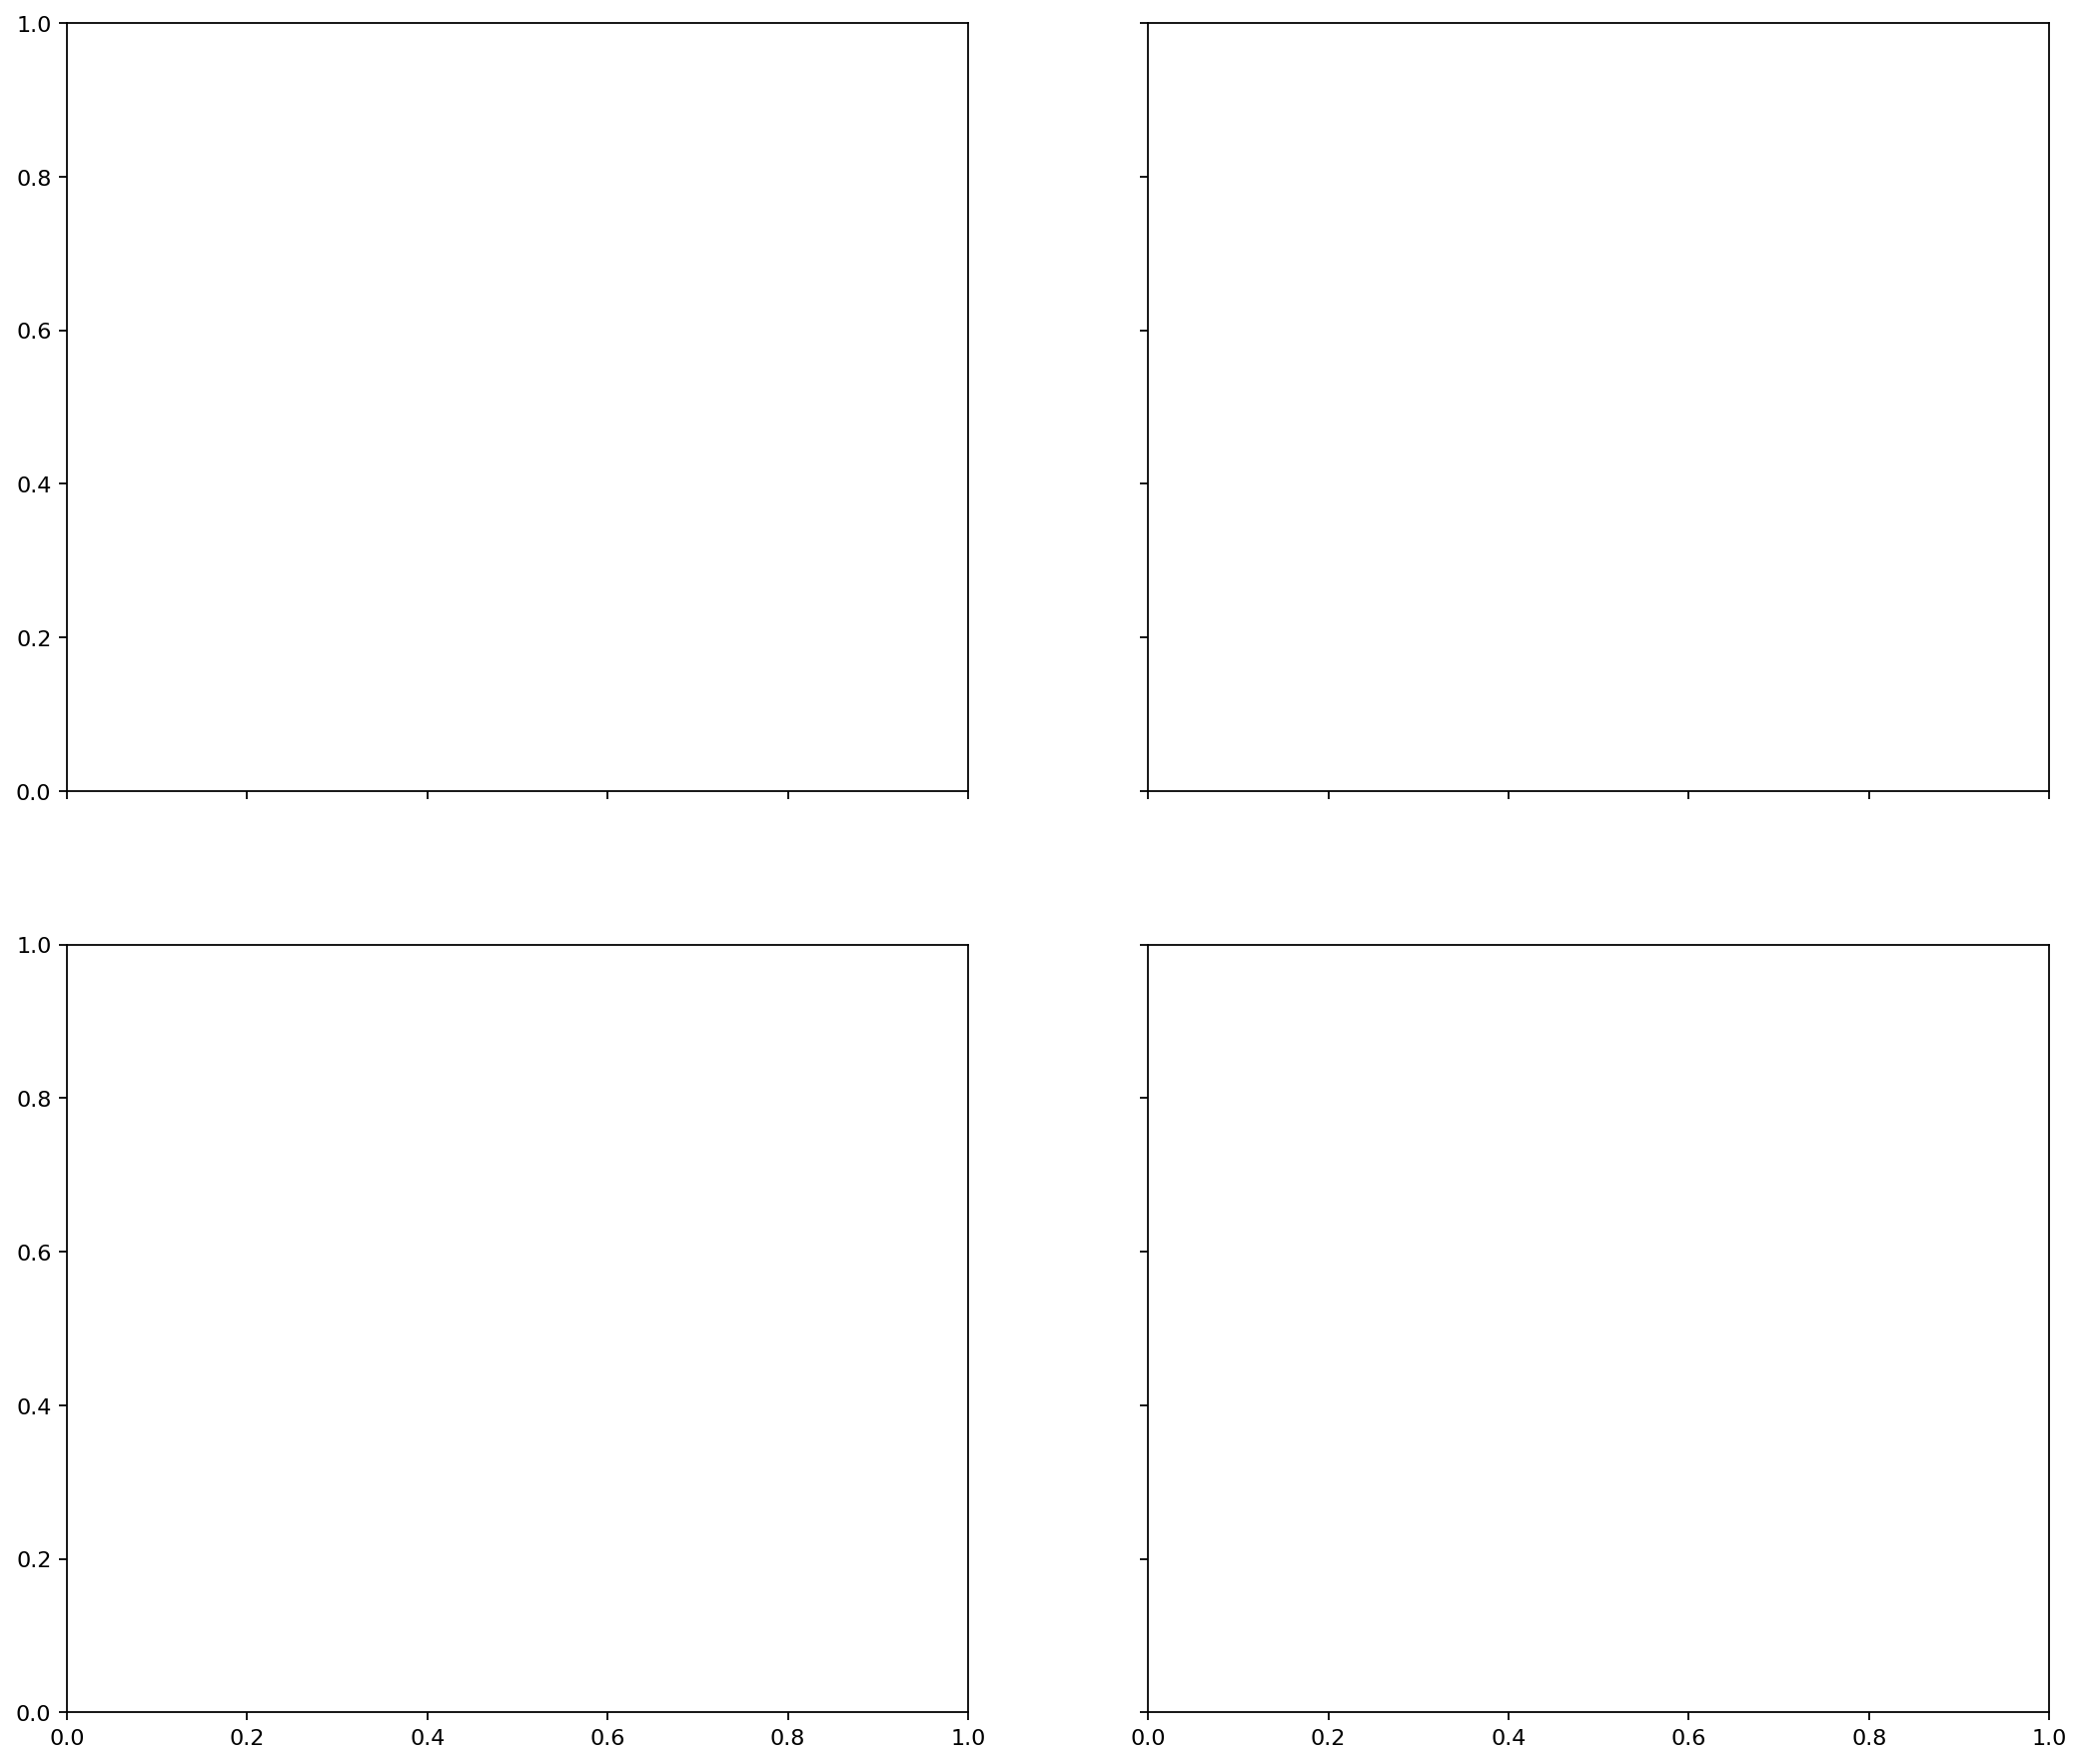

In [4]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [15]:

# Parameters tuning using Grid Search
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tokens_collection = []
#tokens_collection.append(prep_collection)
#for x in prep_collection:
#    tokens_collection.append(np.array(word_tokenize(x)))

vectorizer = CountVectorizer(analyzer='word', min_df=10, stop_words='english', lowercase=True, token_pattern='[a-zA-Z0-9]{3,}', max_features=50000)
data_vectorized = vectorizer.fit_transform(prep_collection)

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
grid_params = {'n_components' : list(range(5,10))}
# LDA model
lda = LatentDirichletAllocation()
lda_model = GridSearchCV(lda,param_grid=grid_params)
lda_model.fit(tokens_collection)
# Estimators for LDA model
lda_model1 = lda_model.best_estimator_
print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", lda_model1.perplexity(tokens_collection))

AttributeError: 'list' object has no attribute 'lower'